# Debugging `percolate`

## 1. Dealing with the random empty clusters

Some structures percolate at a given temperature $T_1$ but not at another temperature $T_2 > T_1$. This is clearly an erroneous result because if a spanning cluster forms at $T_1$, it must also be realisable at $T_2 > T_1$.

In [1]:
%matplotlib widget

from os import path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from qcnico.plt_utils import histogram


def get_dcrits(run_inds,temps,datadir):
    nsamples = len(run_inds)
    ntemps = len(temps)
    dcrits = np.zeros((nsamples,ntemps))
    for k in range(nsamples):
        for l in range(ntemps):
            sampdir = f"sample-{run_inds[k]}"
            pkl = f"out_percolate-{temps[l]}K.pkl"
            fo = open(path.join(datadir,sampdir,pkl),'rb')
            dat = pickle.load(fo)
            dcrits[k,l] = dat[1]
            fo.close()

    return dcrits

datadir=path.expanduser("~/Desktop/simulation_outputs/percolation/40x40/percolate_output")
fgood_runs = path.join(datadir, 'good_runs.txt')
with open(fgood_runs) as fo:
    lines = fo.readlines()

# 'Good run' indices
gr_inds = np.array(list(map(int,[line.rstrip().lstrip() for line in lines])))

# temps = np.arange(0,1050,50)
# temps[0] = 10
temps = np.arange(40,440,10)

dcrits = get_dcrits(gr_inds,temps, datadir)
print(dcrits.shape)

davg_T = np.mean(dcrits,axis=0)
dstd_T = np.std(dcrits,axis=0)
print(davg_T.shape)


(174, 40)
(40,)


Check which structures have increasing critical distances with increasing $T$.

In [5]:
ddiffs = np.diff(dcrits)
print("All critical distances decrease with temperature: ", np.all(ddiffs<=0))

All critical distances decrease with temperature:  True


Ok, so for all structures at all $T$: 
$$\frac{\partial d_c}{\partial T} \le 0\,.$$
Good.

Now let's examine the instances where no percolating cluster is found.

In [3]:
def get_clusters_sizes(run_inds,temps,datadir):
    nsamples = len(run_inds)
    ntemps = len(temps)
    sizes = np.zeros((nsamples,ntemps),dtype=int)
    for k in range(nsamples):
        for l in range(ntemps):
            sampdir = "sample-" + str(run_inds[k]) #fstrings don't work in Numba
            pkl = "out_percolate-" + str(temps[l]) + "K.pkl"
            with open(path.join(datadir,sampdir,pkl),'rb') as fo:
                dat = pickle.load(fo)
                c = dat[0]
            if len(c) > 0:
                sizes[k,l] = len(c[0]) #there is only one cluster each time
            else:
                sizes[k,l] = 0
    return sizes

csizes = get_clusters_sizes(gr_inds,temps,datadir)
zero_cluster_inds = (csizes == 0).nonzero()
print("Sample nb. and temperatures where no percolation occured:")
print(np.vstack((gr_inds[zero_cluster_inds[0]], temps[zero_cluster_inds[1]])).T)

Sample nb. and temperatures where no percolation occured:
[]


Let's check out sample 25 and what happens around $T =150\,\text{K}$.

In [2]:
from qcnico.coords_io import read_xsf

def get_cluster_data(run_ind,nMOs,temps,datadir):
    ntemps = len(temps)
    clusters = []
    adjmats = np.zeros((ntemps,nMOs,nMOs),dtype=bool)
    for l in range(ntemps):
        sampdir = "sample-" + str(run_ind) #fstrings don't work in Numba
        pkl = "out_percolate-" + str(temps[l]) + "K.pkl"
        with open(path.join(datadir,sampdir,pkl),'rb') as fo:
            dat = pickle.load(fo)
            clusters.append(dat[0])
            adjmats[l,:,:] = dat[2]
    return clusters, adjmats

def get_npy_data(nn,datadir):
    posdir = path.join(path.dirname(datadir), 'structures')
    Mdir = path.join(path.dirname(datadir), 'MOs_ARPACK')
    edir = path.join(path.dirname(datadir), 'eARPACK')

    posfile = path.join(posdir,f'bigMAC-{nn}_relaxed.xsf')
    Mfile = path.join(Mdir,f'MOs_ARPACK_bigMAC-{nn}.npy')
    efile = path.join(edir, f'eARPACK_bigMAC-{nn}.npy')
    locfile = path.join(datadir,f'sample-{nn}','cc.npy')
    eefile = path.join(datadir,f'sample-{nn}','ee.npy')
    indfile = path.join(datadir,f'sample-{nn}','ii.npy')
    gamLfile = path.join(datadir,f'sample-{nn}',f'gamL_40x40-{nn}.npy')
    gamRfile = path.join(datadir,f'sample-{nn}',f'gamR_40x40-{nn}.npy')

    pos, _ = read_xsf(posfile)
    M = np.load(Mfile)
    energies = np.load(efile) #energies appear only once (apart from degeneracies)
    loc_centers = np.load(locfile)
    ee = np.load(eefile) #each energy appears as many times as its associated has localisation centres
    ii = np.load(indfile)
    gamL = np.load(gamLfile)
    gamR = np.load(gamRfile)

    return pos, M, energies, loc_centers, ee, ii, gamL, gamR


gr_nn = 12 #zero_cluster_inds[0][0]
nn = gr_inds[gr_nn] # should equal 25
print(nn)
Tsample_inds = np.array([0,10,11,12,-1])
Tsample = temps[Tsample_inds]
_, _, _, loc_centers, ee, *_ = get_npy_data(nn,datadir)

clusters, adjmats = get_cluster_data(25,loc_centers.shape[0],temps,datadir)

25


In [3]:

dd25 = dcrits[gr_nn,:]
cs25 = csizes[gr_nn,:]

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(temps,dd25,'r-',lw=0.8)
axs[1].plot(temps,cs25,'r-',lw=0.8)
axs[0].set_ylabel('$d_c$')          
axs[1].set_xlabel('$T$ [K]')
axs[1].set_ylabel('Cluster size')
plt.show()

NameError: name 'csizes' is not defined

In [6]:
from percolate import diff_arrs

kB = 8.617e-5
T = 150 #K

edarr, rdarr = diff_arrs(ee,loc_centers,a0=30,eF=0)
MA_dists = (edarr/(kB*T)) +  rdarr
print(np.max(MA_dists))
print(dd25[11])


57.03931987097846
22.55973310076784


Figured out the issue; turns out the `percolate` function returned an empty cluster upon reaching the $N^{\text{th}}$ distance, as oppose to the ${N(N-1)/2}^{\text{th}}$ (in increasing order). In other words, it thought it was finished looking at all the inter-centre distances in the structure, when in fact, it still had a bunch more distances to check. 
Issue is fixed now.

Now onto the next issue.

## Clusters with only two overlapping centers

Some clusters are comprised of only two localisation centres whose spatial position overlap. This does not seem correct, as the likelihood of having two MOs coupled to opposite edges coarse-grained to the same localisation centre is quite small. It is possible though, if we have an MO with split localisation on both edges. Let's investigate.

In [7]:
minsize = np.min(csizes)
print("Minimum cluster size = ", minsize)

tiny_cluster_inds = (csizes == minsize).nonzero()
nn = gr_inds[tiny_cluster_inds[0][0]]
Tsample = temps[tiny_cluster_inds[1]]

pos, M, energies, loc_centers, ee, ii, gamL, gamR  = get_npy_data(nn, datadir)

tiny_clusters, _ = get_cluster_data(nn, ee.shape[0],Tsample,datadir)
tiny_clusters = np.array([list(c) for c in tiny_clusters])
print('All tiny clusters are the same: ', np.all(np.all(tiny_clusters == tiny_clusters[0,:],axis=1)))



Minimum cluster size =  9
All tiny clusters are the same:  True


Only one structure exhibits a 'tiny cluster'. It is the same one at all temperatures where it arises.
Now let's examine the couplings.

In [8]:
tc = np.array(list(tiny_clusters[0][0]))
print('Tiny cluster (loc center inds) = ', tc)
print('Tiny cluster (MO inds) = ', ii[tc])
print('Left couplings of the tiny cluster = ', gamL[ii[tc]])
print('Right couplings of the tiny cluster = ', gamR[ii[tc]])

print('Gamma_L tolerance = ', np.mean(gamL) + 3.0*np.std(gamL))
print('Gamma_R tolerance = ', np.mean(gamR) + 3.0*np.std(gamR))



Tiny cluster (loc center inds) =  [ 32  33 164  11  12 141 142  16  24]
Tiny cluster (MO inds) =  [ 20  21 101   7   8  85  85  11  16]
Left couplings of the tiny cluster =  [1.36892732e-03 3.78842900e-03 8.36784249e-06 2.49329135e-07
 2.56774698e-06 6.90463215e-06 6.90463215e-06 6.61300407e-09
 1.38198017e-04]
Right couplings of the tiny cluster =  [0.00172769 0.00082447 0.00175748 0.00673193 0.00287175 0.00038355
 0.00038355 0.00015026 0.00065018]
Gamma_L tolerance =  0.0034154596971000457
Gamma_R tolerance =  0.0032372653181356923


In [8]:
from qcnico.qcplots import plot_MO

for i in ii[tc]:
    fig, ax = plt.subplots()
    plot_MO(pos,M,i,dotsize=1.0,show_COM=True,usetex=False,show=True,plt_objs=(fig,ax))

NameError: name 'ii' is not defined

In [9]:
from percolate import get_MO_loc_centers
from qcnico.qchemMAC import gridifyMO
from qcnico.qcplots import plot_MO
     
nbins = 20
threshold_ratio = 0.60

for i in ii[tc]:
    fig, ax = plt.subplots()
    rho, xedges, yedges = gridifyMO(pos ,M, i, nbins,True)
    print(xedges)
    print('ARGMAX(rho) = ', np.unravel_index(np.argmax(rho),shape=rho.shape))
    cc = np.array(get_MO_loc_centers(pos,M,i,nbins,threshold_ratio,return_realspace=True))
    if cc.shape[0] == 1: cc = cc[0,:]
    print('cc = ', cc)
    ax.set_title("Coarse grained $\langle\\varphi|\psi_{%d}\\rangle$"%i)
    ax.imshow(rho, origin='lower',extent=[*xedges[[0,-1]], *yedges[[0,-1]]])
    ax.scatter(*cc.T,c='r',marker='*',s=5.0)
    plt.show()
    
    


NameError: name 'ii' is not defined

In [11]:
Xmin = np.inf
Ymin = np.inf
Xmax = -np.inf
Ymax = -np.inf

posdir = path.join(path.dirname(datadir), 'structures')

for nn in gr_inds:
    pos, _ = read_xsf(path.join(posdir,f'bigMAC-{nn}_relaxed.xsf'))
    xmin = np.min(pos[:,0])
    ymin = np.min(pos[:,1])
    xmax = np.max(pos[:,0])
    ymax = np.max(pos[:,1])
    if xmin < Xmin: Xmin = xmin
    if ymin < Ymin: Ymin = ymin
    if xmax > Xmax: Xmax = xmax
    if ymax > Ymax: Ymax = ymax

print(Xmin,Ymin)
print(Xmax,Ymax)

-1.01596 -1.06803
401.14 400.661


## Checking MO-lead couplings

Check if any MOs in our ensemble are strongly coupled to both leads.


In [12]:
def check_double_couplings(nn,datadir,tolscal):
    *_, gamL, gamR = get_npy_data(nn, datadir)
    ltol = np.mean(gamL) + tolscal*np.std(gamL)
    rtol = np.mean(gamR) + tolscal*np.std(gamR)
    L = set((gamL > ltol).nonzero()[0])
    R = set((gamR > rtol).nonzero()[0])
    return L & R

for nn in gr_inds:
    dbl_cpl_inds = check_double_couplings(nn,datadir,tolscal=3.0)
    if len(dbl_cpl_inds) > 0:
        print('*****************')
        print(nn, dbl_cpl_inds)
        print('*****************')
        pos, M, *_  = get_npy_data(nn, datadir)
        for n in dbl_cpl_inds:
            fig, ax = plt.subplots()
            plot_MO(pos,M,n,usetex=False,dotsize=1.0,show=True,plt_objs=(fig,ax))
        




## Check hopping site-lead couplings

Check if our ensemble contains any problematic sites that are strongly coupled to a given lead while being on the opposite side of the structure.

In [3]:
#from percolate import plot_loc_centers
from percolate import get_MO_loc_centers
from qcnico.qchemMAC import gridifyMO
from qcnico.qcplots import plot_MO
     
nbins = 20
threshold_ratio = 0.60

def plot_loc_centers(rho, xedges, yedges, centers, colours='r', show=True, plt_objs=None):

    if plt_objs is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt_objs
    
    ax.imshow(rho, origin='lower',extent=[*xedges[[0,-1]], *yedges[[0,-1]]])
    ax.scatter(*centers.T,c=colours,marker='*',s=5.0)
    if show:
        plt.show()


def check_bad_sites(nn, datadir, tolscal=3.0,visualise=False):
    pos, M, _, loc_centers, _, ii, gamL, gamR = get_npy_data(nn,datadir)
    ltol = np.mean(gamL) + tolscal*np.std(gamL)
    rtol = np.mean(gamR) + tolscal*np.std(gamR)
    L = set((gamL > ltol).nonzero()[0])
    R = set((gamR > rtol).nonzero()[0])

    x = pos[:,0]
    l = np.max(x) - np.min(x)
    # print(f"Length = {l} å")
    midx = l/2

    nbadsites = 0

    # print('** Left **')
    for n in L:
        # print(f' ---- State {n}; gamL = {gamL[n]}; gamR = {gamR[n]} ----')
        sites = loc_centers[ii==n]
        badsites = sites[sites[:,0] > midx]
        if badsites.shape[0] > 0:
            nbadsites += badsites.shape[0]
            # print(f'Found {badsites.shape[0]} bad sites!')
            if visualise:
                fig, ax = plt.subplots()
                plot_MO(pos,M,n,dotsize=1.0,usetex=False,show=False,plt_objs=(fig,ax))
                ax.axvline(x=midx,ymin=0,ymax=1,c='dodgerblue',ls='--',lw=0.8)
                plt.show()
                
                clrs = ['red' if (i in badsites) else 'lime' for i in sites]

                fig, ax = plt.subplots()
                rho, xedges, yedges = gridifyMO(pos,M,n,nbins=20,pad_rho=True,return_edges=True)
                plot_loc_centers(rho, xedges, yedges,sites,colours=clrs,show=False,plt_objs=(fig,ax))
                ax.axvline(x=midx,ymin=0,ymax=1,c='dodgerblue',ls='--',lw=0.8)
                ax.set_title("Coarse grained $\langle\\varphi|\psi_{%d}\\rangle$"%n)
                plt.show()
    
    # print('** Right **')
    for n in R:
        # print(f' ---- State {n}; gamL = {gamL[n]}; gamR = {gamR[n]} ----')
        sites = loc_centers[ii==n]
        badsites = sites[sites[:,0] < midx]
        if badsites.shape[0] > 0:
            nbadsites += badsites.shape[0]
            # print(f'Found {badsites.shape[0]} bad sites!')
            if visualise:
                fig, ax = plt.subplots()
                plot_MO(pos,M,n,dotsize=1.0,usetex=False,show=False,plt_objs=(fig,ax))
                ax.axvline(x=midx,ymin=0,ymax=1,c='dodgerblue',ls='--',lw=0.8)
                plt.show()
                
                clrs = ['red' if (i in badsites) else 'lime' for i in sites]

                fig, ax = plt.subplots()
                rho, xedges, yedges = gridifyMO(pos,M,n,nbins=20,pad_rho=True,return_edges=True)
                plot_loc_centers(rho, xedges, yedges,sites,colours=clrs,show=False,plt_objs=(fig,ax))
                ax.axvline(x=midx,ymin=0,ymax=1,c='dodgerblue',ls='--',lw=0.8)
                ax.set_title("Coarse grained $\langle\\varphi|\psi_{%d}\\rangle$"%n)
                plt.show()
    
    return nbadsites


In [4]:
Nbadsites = 0
worst_nbs = -np.inf
worst_struc = 0
bad_strucs = []
for nn in gr_inds:
    print(f'******* {nn} *******')
    nbs = check_bad_sites(nn, datadir, visualise=False)
    Nbadsites += nbs
    if nbs > 0: bad_strucs.append(nn)
    if nbs > worst_nbs:
        worst_nbs = nbs
        worst_struc = nn

print(f"Found {Nbadsites} problematic sites in total.")
print("Problematic structures = ", bad_strucs)
print(f"Sample nb. {worst_struc} had the most problematic sites ({worst_nbs}).")

******* 2 *******
******* 5 *******
******* 6 *******
******* 9 *******
******* 13 *******
******* 14 *******
******* 15 *******
******* 16 *******
******* 17 *******
******* 19 *******
******* 21 *******
******* 23 *******
******* 25 *******
******* 27 *******
******* 28 *******
******* 29 *******
******* 30 *******
******* 32 *******
******* 33 *******
******* 34 *******
******* 36 *******
******* 37 *******
******* 38 *******
******* 39 *******
******* 40 *******
******* 41 *******
******* 43 *******
******* 44 *******
******* 45 *******
******* 48 *******
******* 49 *******
******* 50 *******
******* 51 *******
******* 52 *******
******* 54 *******
******* 55 *******
******* 56 *******
******* 57 *******
******* 58 *******
******* 60 *******
******* 69 *******
******* 70 *******
******* 72 *******
******* 73 *******
******* 75 *******
******* 80 *******
******* 81 *******
******* 82 *******
******* 83 *******
******* 84 *******
******* 86 *******
******* 87 *******
******* 88 *****

******* 70 *******


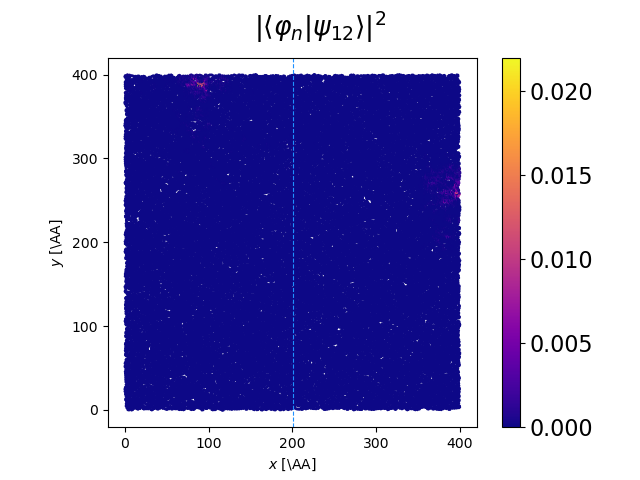

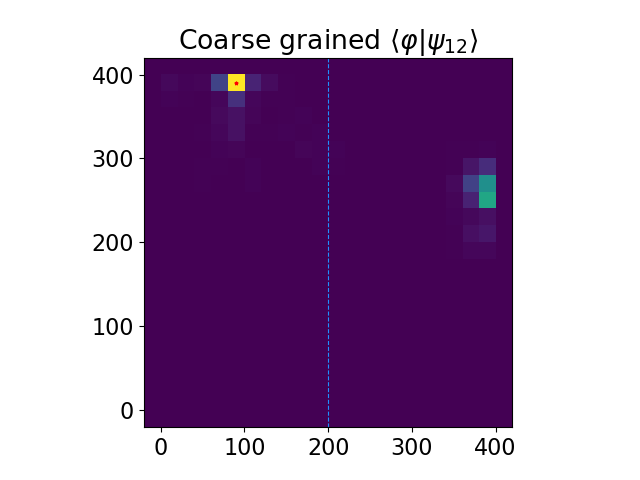

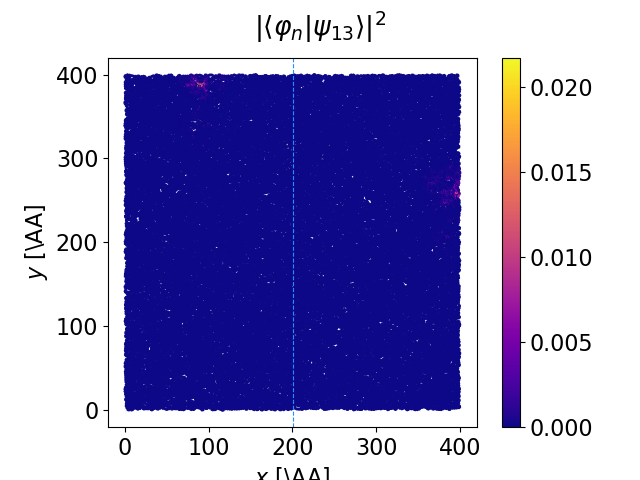

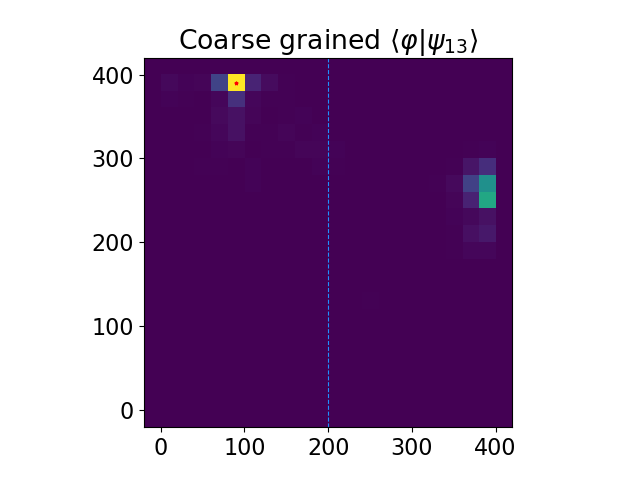

In [5]:
for s in bad_strucs[1:2]:
    print(f"******* {s} *******")
    _, check_bad_sites(s, datadir, visualise=True)

In [13]:
from percolate import bin_centers
from scipy.signal import find_peaks

def get_MO_loc_centers_pynb(pos, M, n, nbins=20, threshold_ratio=0.60,return_realspace=True,padded_rho=True,return_gridify=False):
    rho, xedges, yedges = gridifyMO(pos, M, n, nbins,True)
    if padded_rho:
        nbins = nbins+2 #nbins describes over how many bins the actual MO is discretized; doesn't account for padding
    
    all_peaks = {}
    for i in range(1,nbins-1):
        data = rho[i,:]
        peak_inds, _ = find_peaks(data)
        for j in peak_inds:
            peak_val = data[j]
            if peak_val > 1e-4: all_peaks[(i,j)] = peak_val

    threshold = max(all_peaks.values())*threshold_ratio
    peaks = {key:val for key,val in all_peaks.items() if val >= threshold}

    # Some peaks still occupy several neighbouring pixels; keep only the most prominent pixel
    # so that we have 1 peak <---> 1 pixel.
    pk_inds = set(peaks.keys())
    shift = np.array([[0,1],[1,0],[1,1],[0,-1],[-1,0],[-1,-1],[1,-1],[-1,1]])
    
    while pk_inds:
        ij = pk_inds.pop()
        nns = set(tuple(nm) for nm in ij + shift)
        intersect = nns & pk_inds
        for nm in intersect:
            if peaks[nm] <= peaks[ij]:
                #print(nm, peaks[nm])
                peaks[nm] = 0
            else:
                peaks[ij] = 0

    #need to swap indices of peak position; 1st index actually labels y and 2nd labels x
    peak_inds = np.roll([key for key in peaks.keys() if peaks[key] > 0],shift=1,axis=1)
    #peak_inds = np.array([key for key in peaks.keys() if peaks[key] > 0])
    if return_realspace and return_gridify:
        return bin_centers(peak_inds,xedges,yedges), rho, xedges, yedges
    elif return_realspace and (not return_gridify):
        return bin_centers(peak_inds,xedges,yedges)
    elif return_gridify and (not return_realspace):
        return peak_inds, rho, xedges, yedges
    else:
        return peak_inds
    

def correct_peaks(sites, pos, rho, xedges, yedges, side):

    x = pos[:,0]
    length = np.max(x) - np.min(x)
    midx = length/2

    if side == 'L':
        goodbools = sites[:,0] < midx
    else: # <==> side == 'R'
        goodbools = sites[:,0] > midx
    
    # First, remove bad sites
    sites = sites[goodbools]

    # Check if any sites are left, if not, add peak on the right edge, at the pixel with the highest density
    if not np.any(goodbools):
        print('!!! Generating new peaks !!!')
        if side == 'L':
            edge_ind = 1
        else: # <==> side == 'R' 
            edge_ind = -3
        peak_ind = np.argmax(rho[:,edge_ind]) -1 

        sites = bin_centers([(edge_ind,peak_ind)],xedges,yedges)
        print(sites)
    
    return sites


def generate_site_list_pynb(pos,M,ii,L,R,energies,nbins=20,threshold_ratio=0.60):
    centres = np.zeros(2) #setting centers = [0,0] allows us to use np.vstack when constructing centres array
    ee = []
    inds = []
    #for n in range(M.shape[1]):
    for n in ii:
        cc, rho, xedges, yedges = get_MO_loc_centers_pynb(pos,M,n,nbins,threshold_ratio,return_gridify=True)
        if n in L:
            print(n)
            cc = correct_peaks(cc, pos, rho, xedges, yedges,'L')
        
        elif n in R:
            print(n)
            cc = correct_peaks(cc, pos, rho, xedges, yedges,'R')
        

        centres = np.vstack([centres,cc])
        ee.extend([energies[n]]*cc.shape[0])
        inds.extend([n]*cc.shape[0]) #this will help us keep track of which centers belong to which MOs
    return centres[1:,:], np.array(ee), np.array(inds) #get rid of initial [0,0] entry in centres

L =  {0, 3}
R =  {92, 78}
******* Left *******
0
3


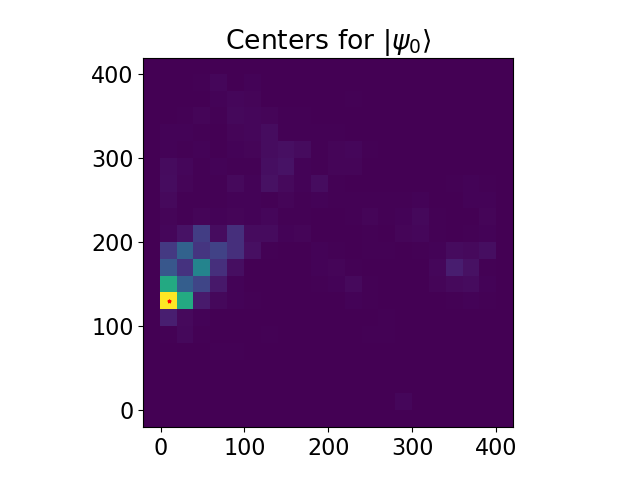

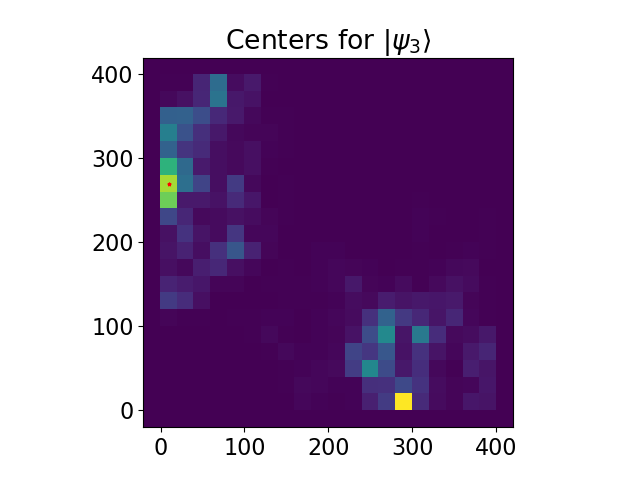

******* Right *******
92
78


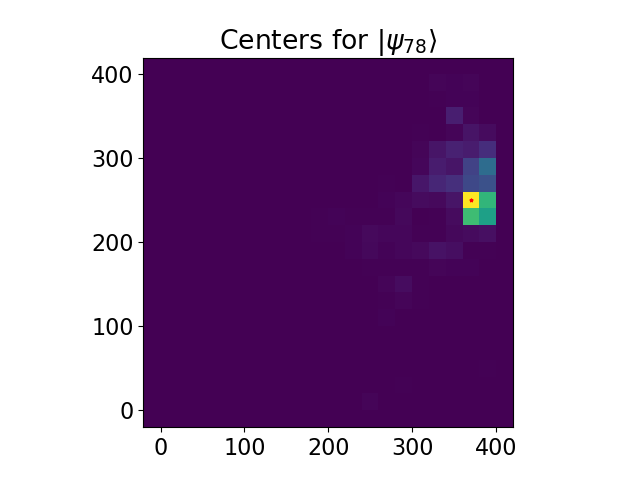

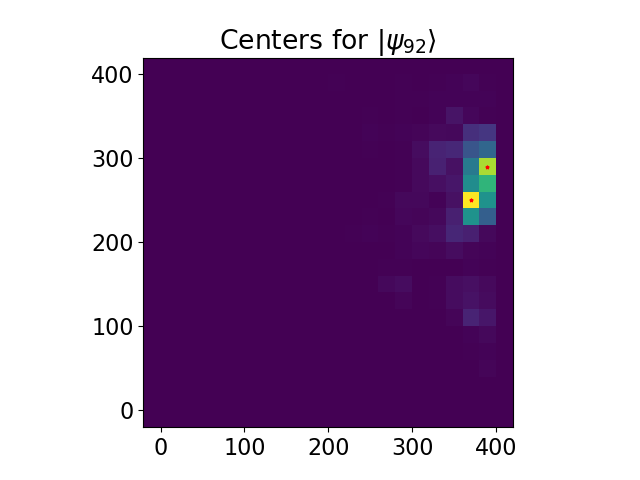

L =  {89, 1}
R =  {100, 37, 12, 13}
******* Left *******
89
1


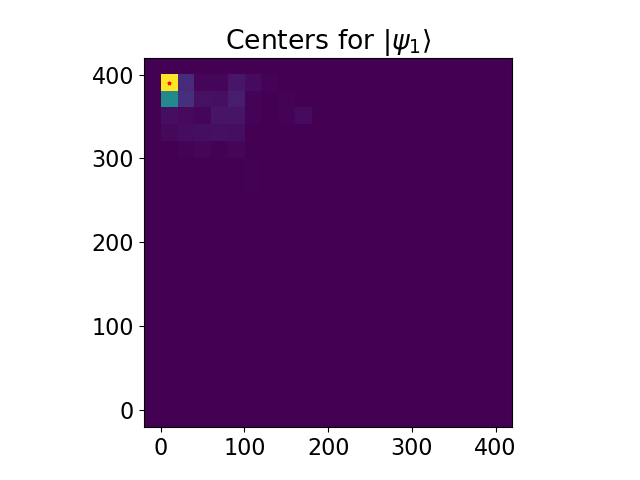

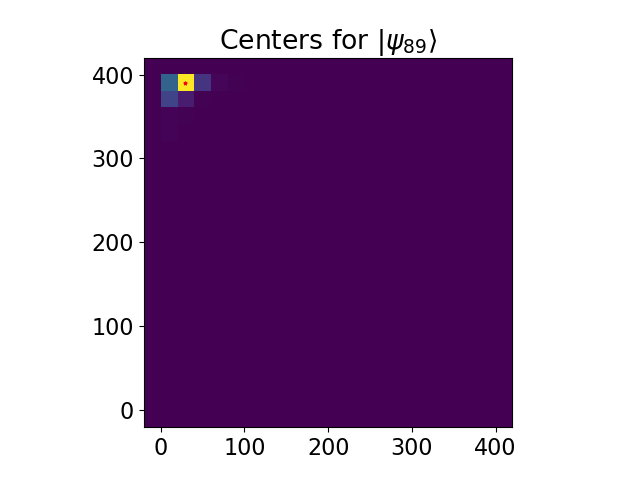

******* Right *******
100
37
12
!!! Generating new peaks !!!
[[390.13479993 249.95195613]]
13
!!! Generating new peaks !!!
[[390.13479993 249.95195613]]


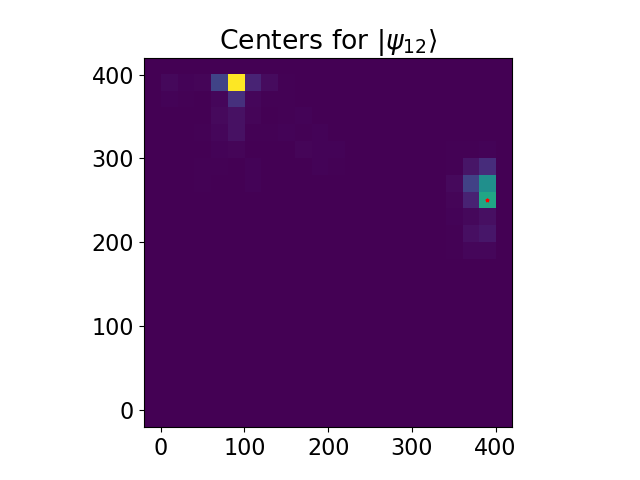

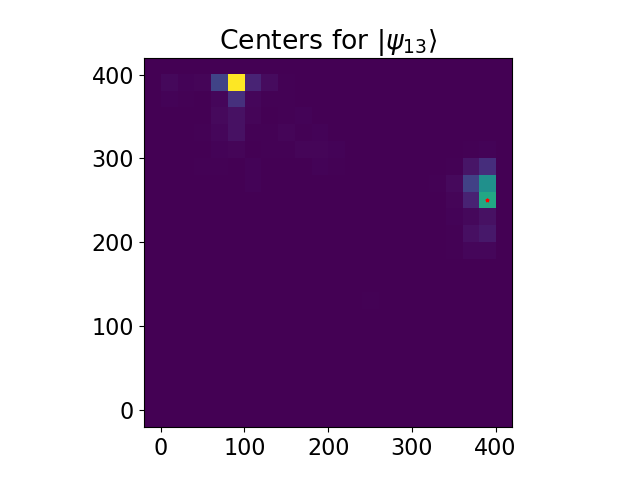

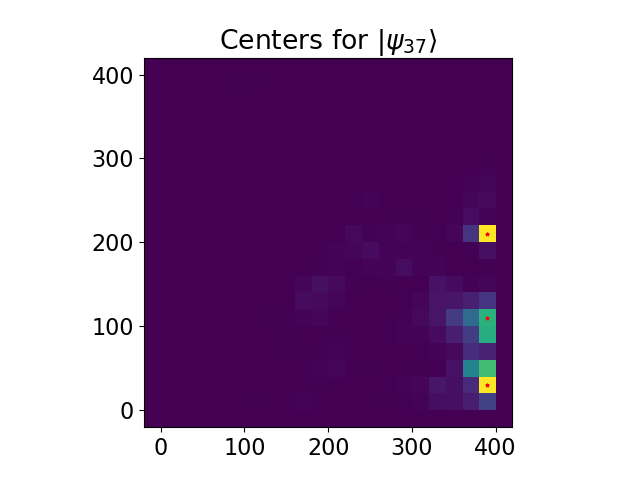

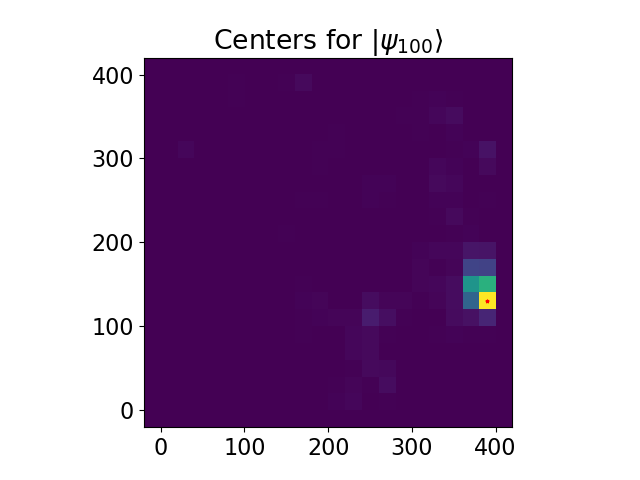

L =  {86, 99, 6}
R =  {1, 2}
******* Left *******
86
99
6


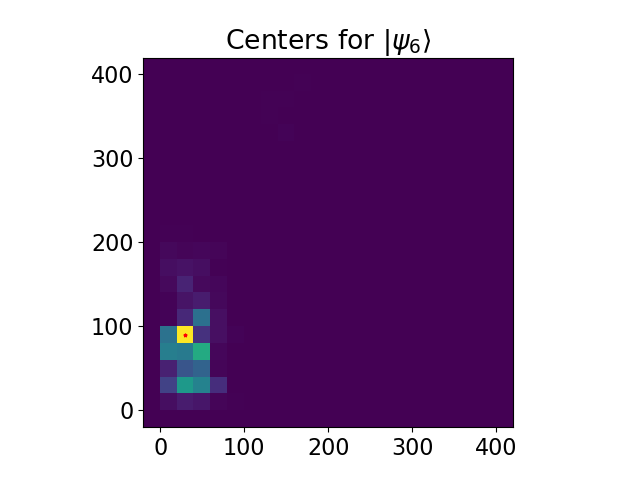

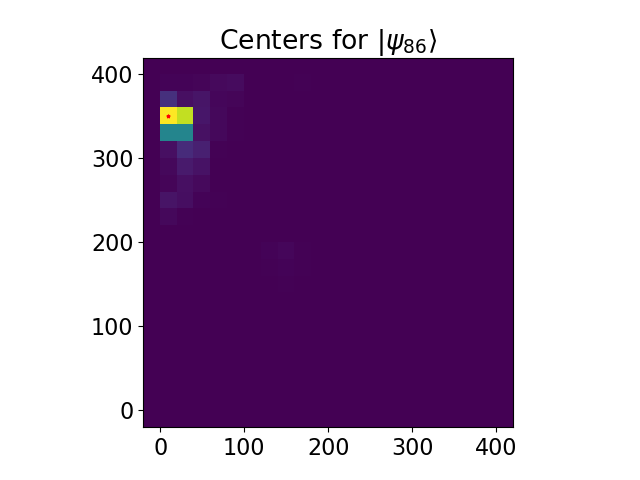

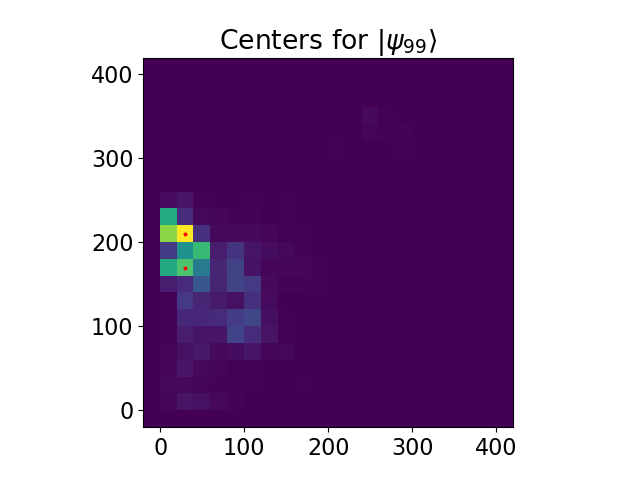

******* Right *******
1
2


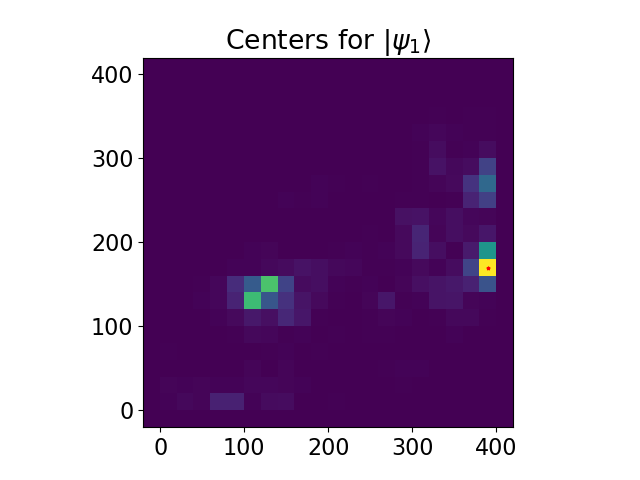

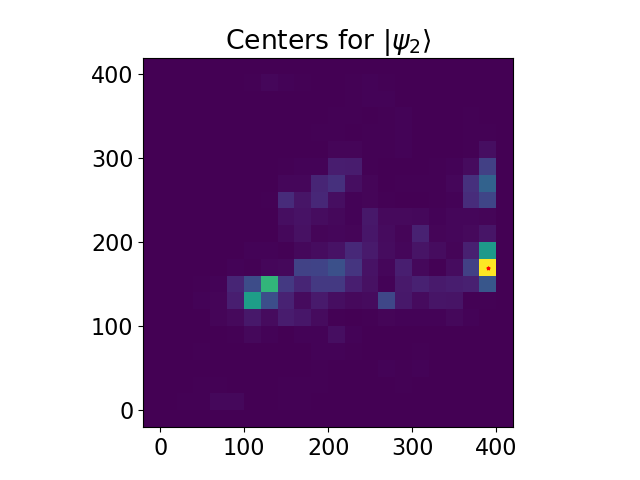

L =  {56, 97, 105}
R =  {33, 20, 54}
******* Left *******
56
97
105


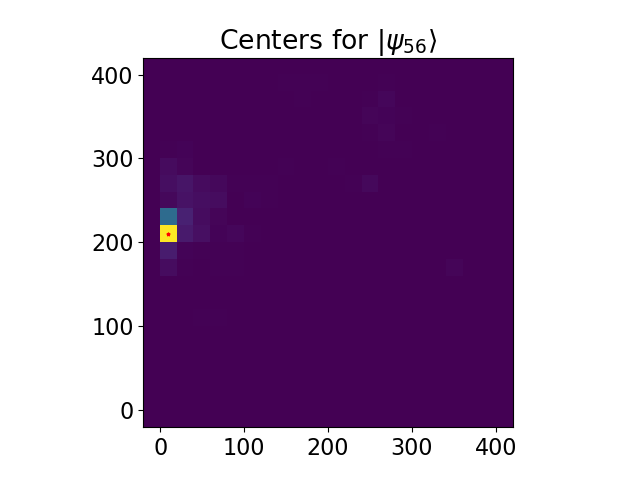

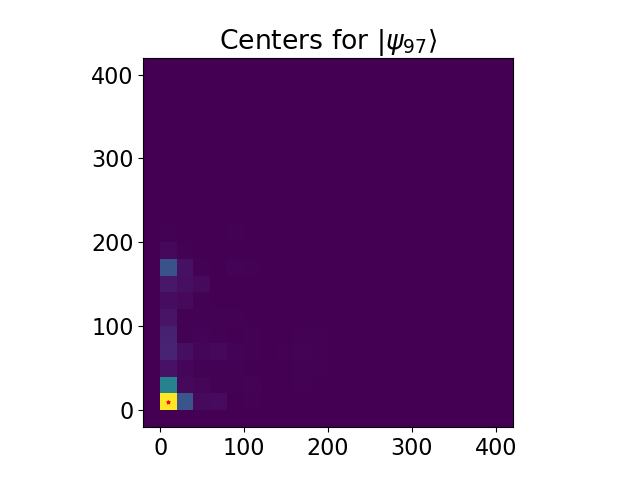

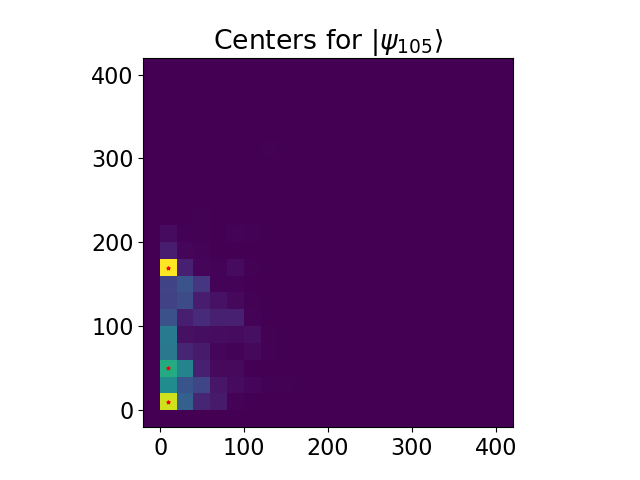

******* Right *******
33
20
54


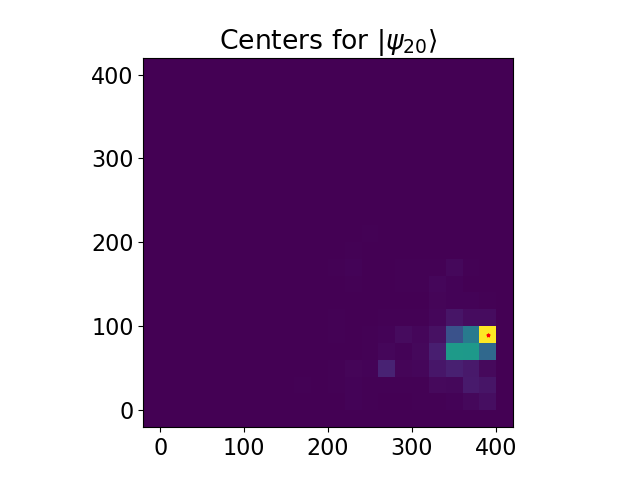

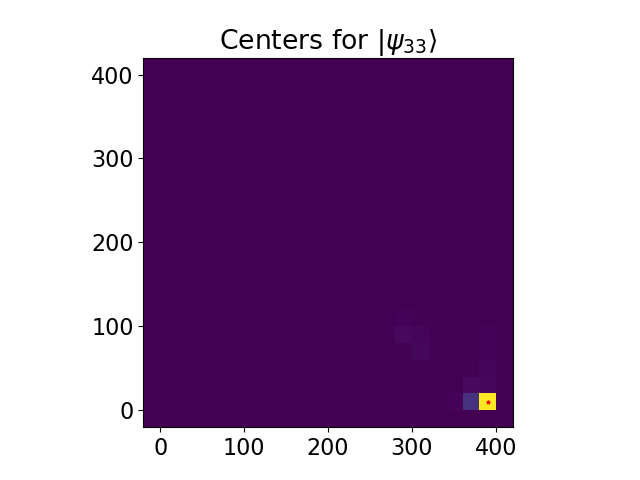

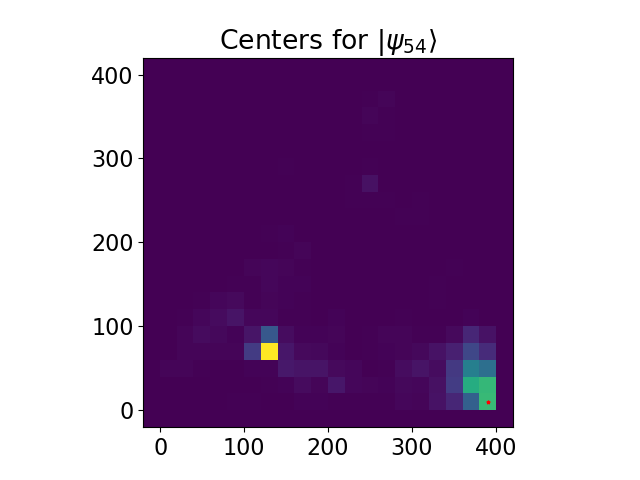

L =  {91, 92, 118}
R =  {40, 117}
******* Left *******
91
92
118


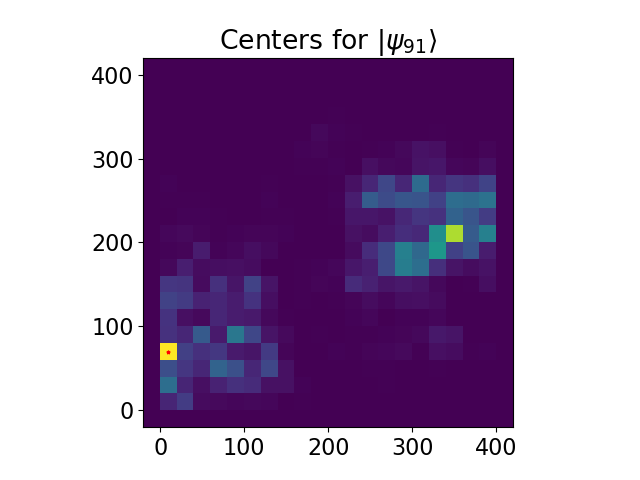

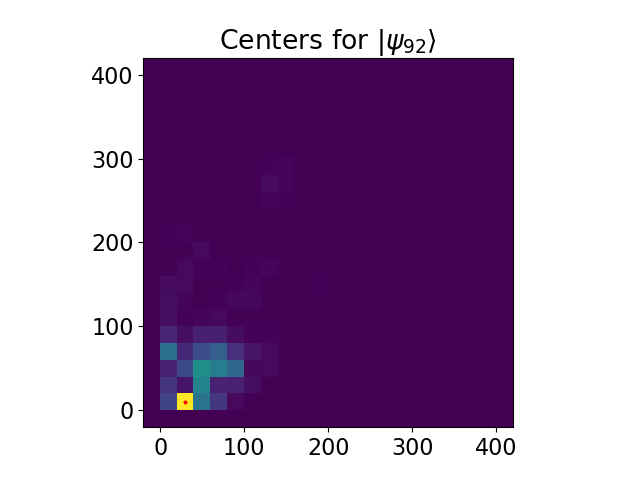

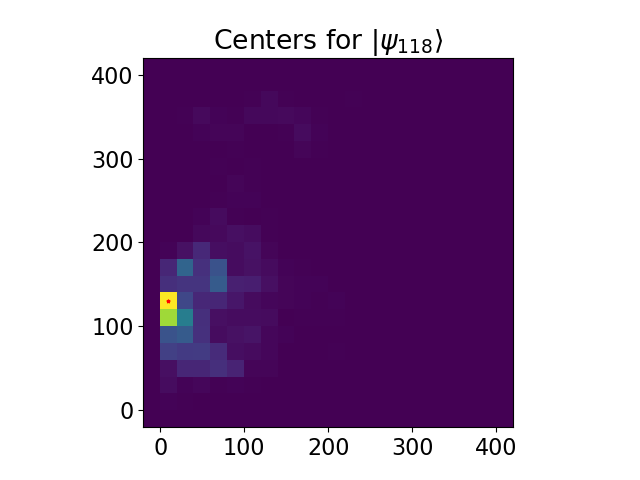

******* Right *******
40
117


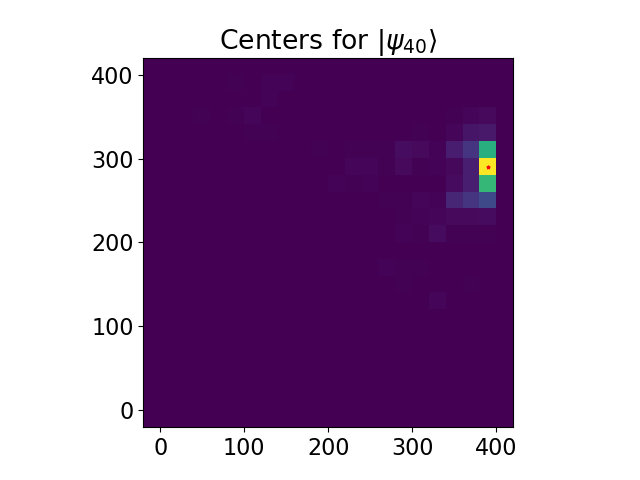

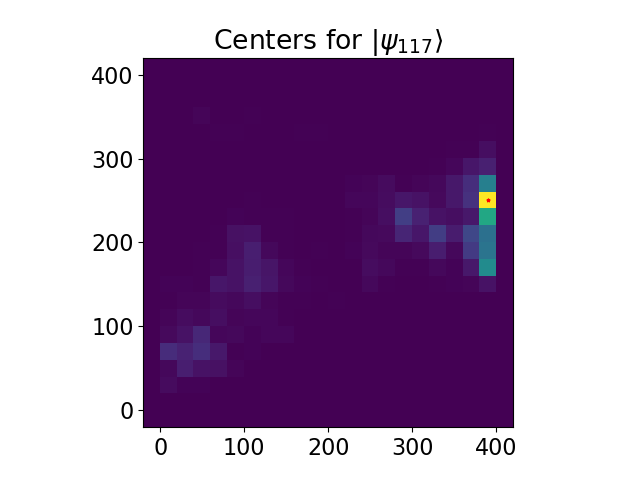

L =  {83, 108, 21}
R =  {24, 25, 7}
******* Left *******
83
108
21


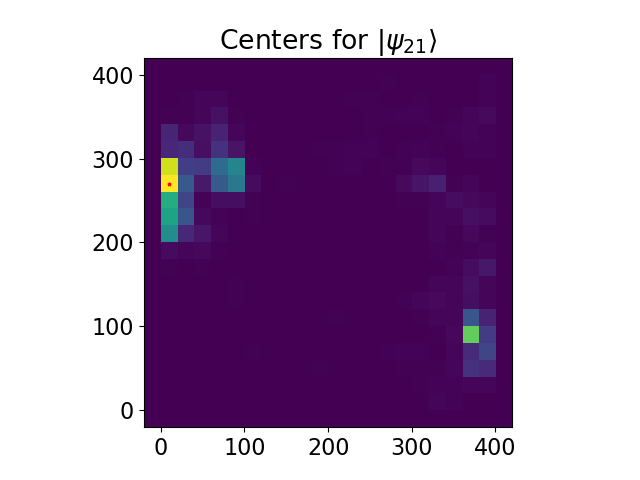

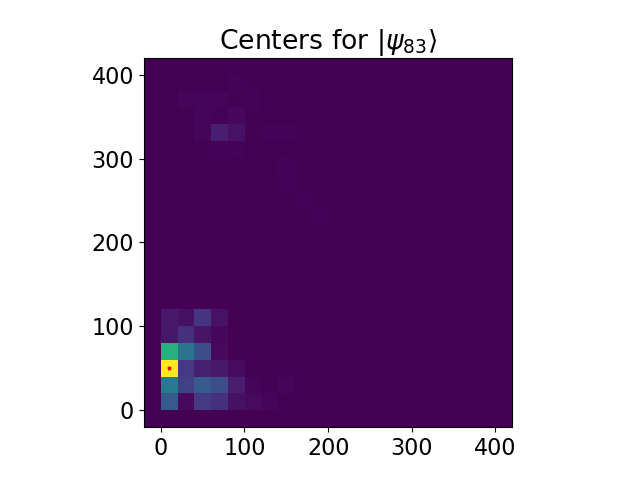

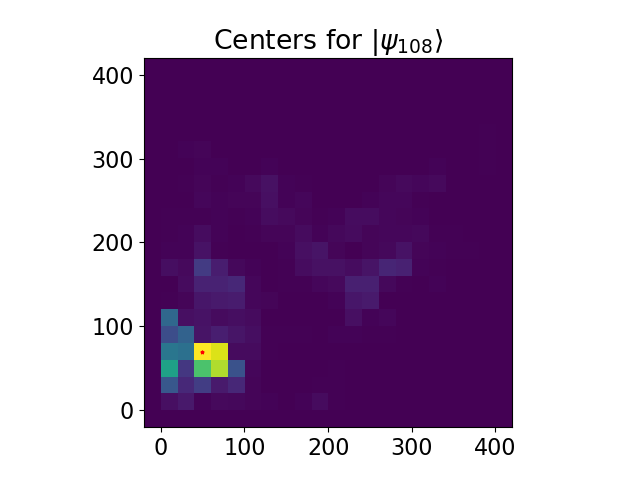

******* Right *******
24
25
7


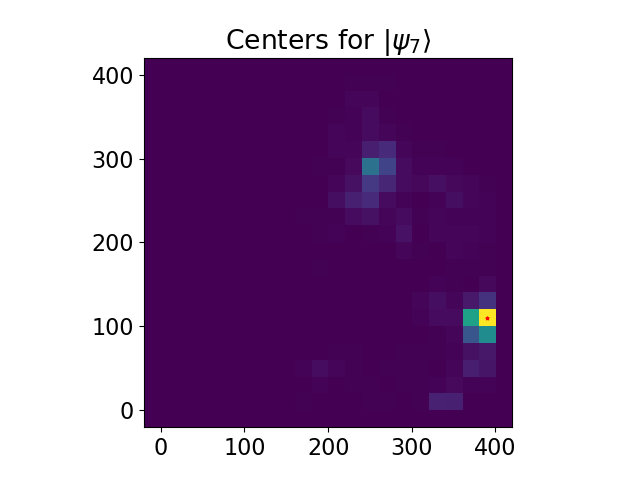

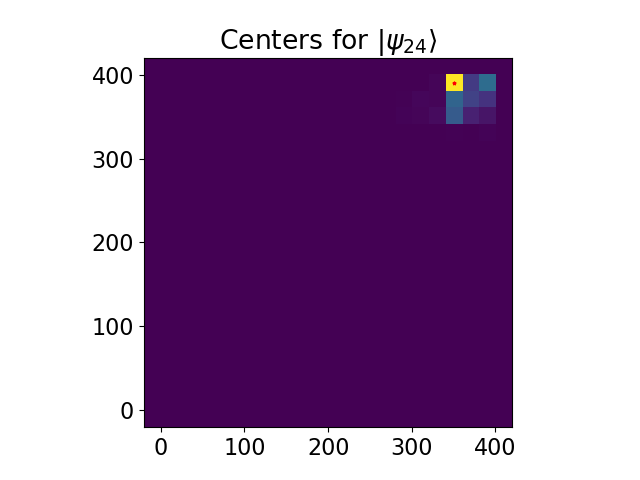

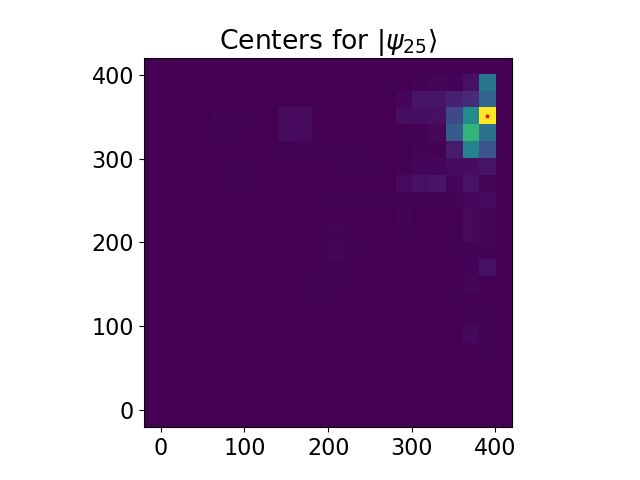

L =  {56, 111, 14, 55}
R =  {11, 4, 63}
******* Left *******
56
111
14
55


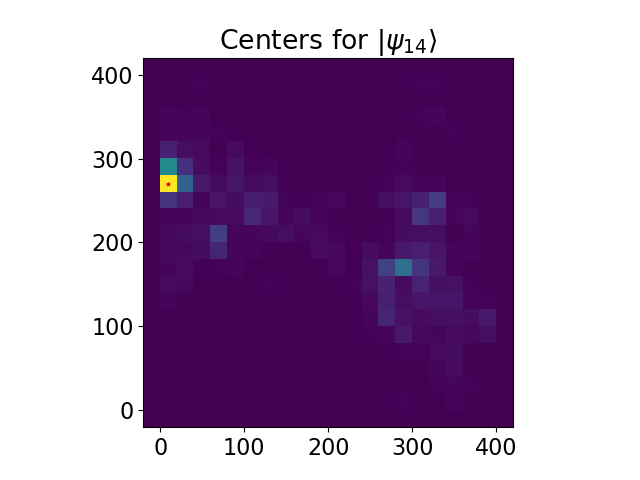

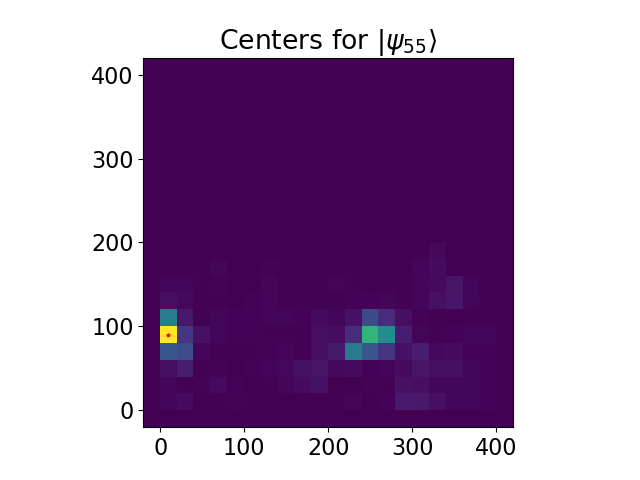

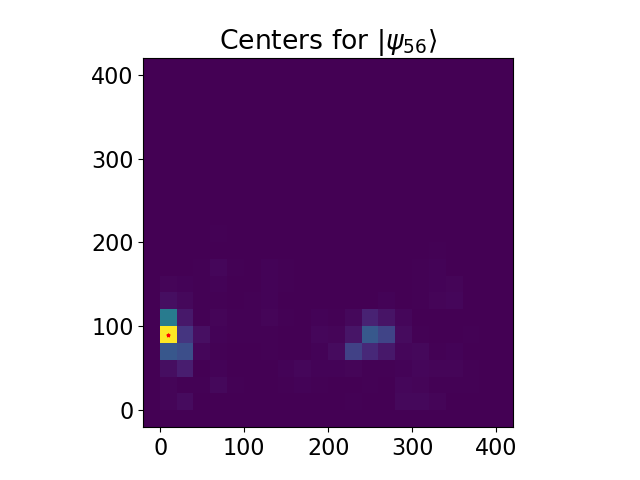

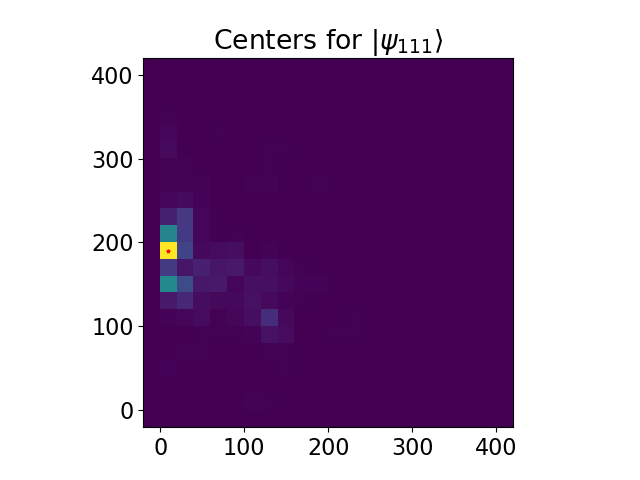

******* Right *******
11
4
63


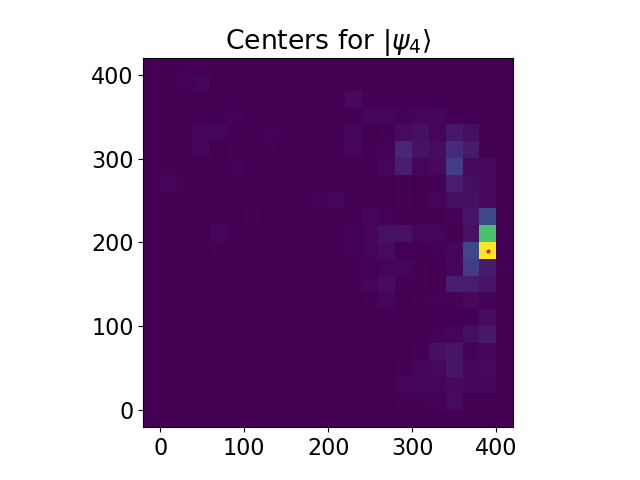

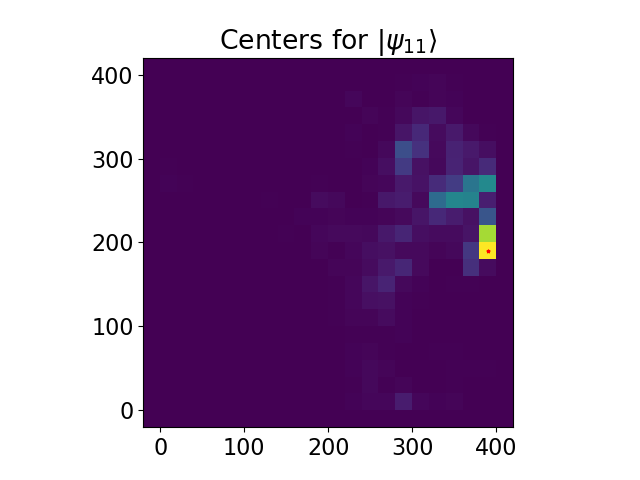

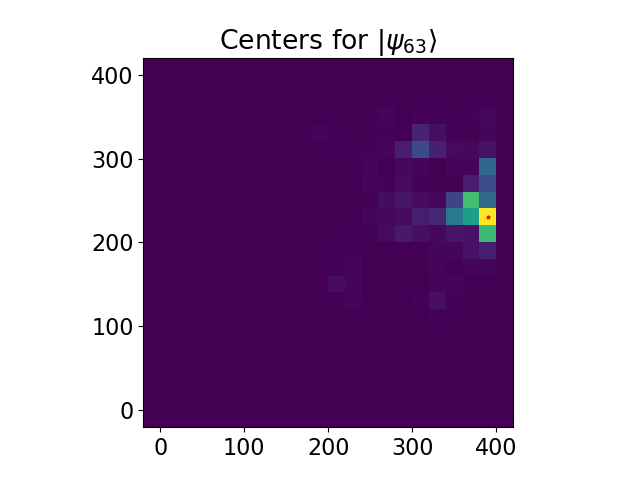

L =  {39, 42, 50, 85, 24}
R =  {29, 69, 21}
******* Left *******
39
42
50
85
24


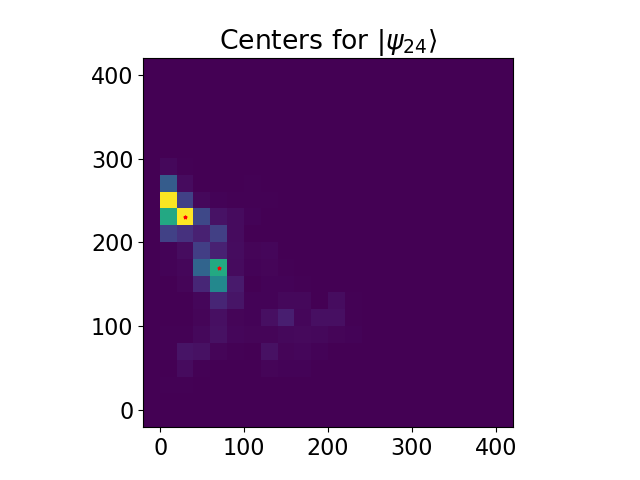

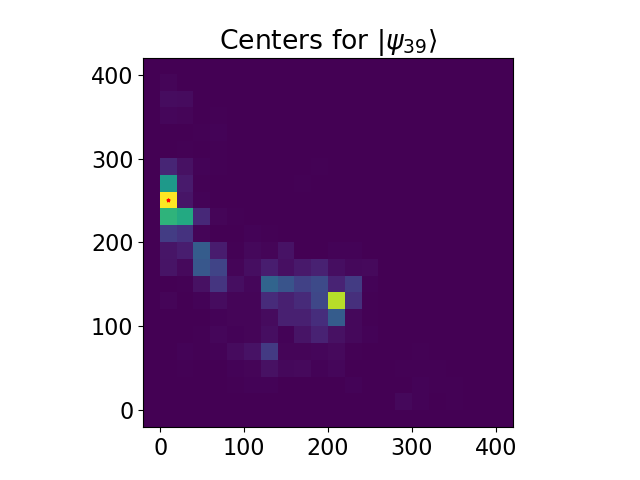

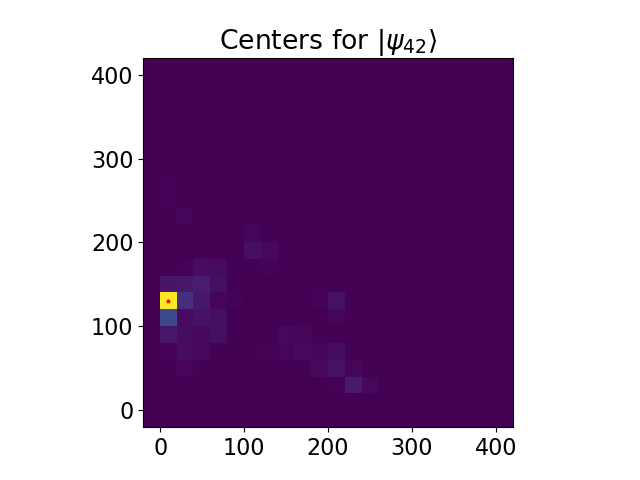

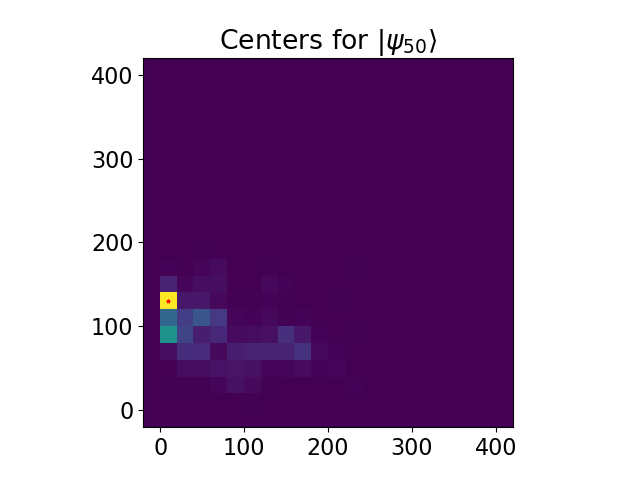

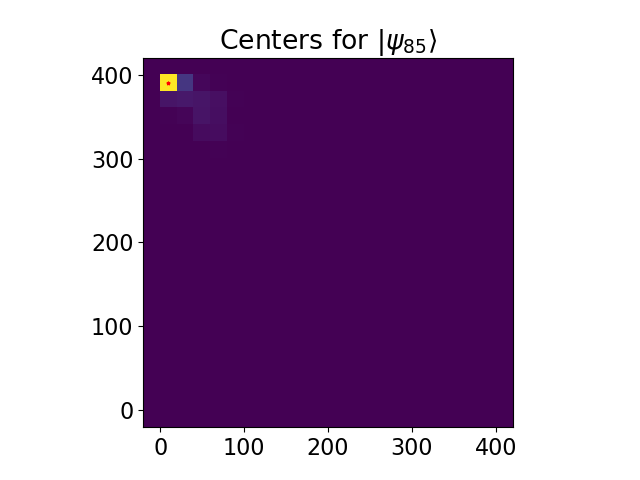

******* Right *******
29
69
21


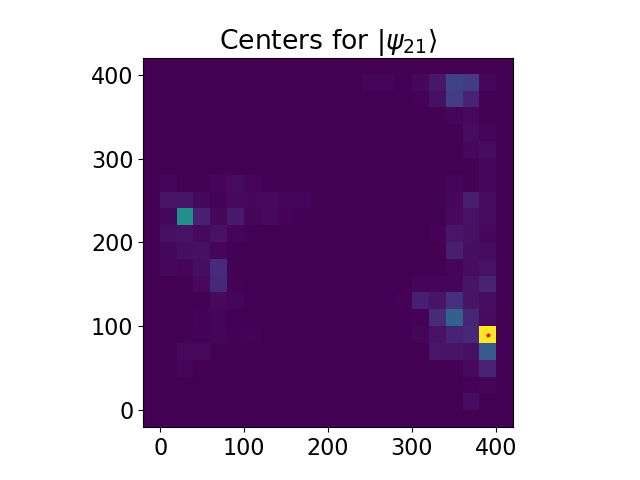

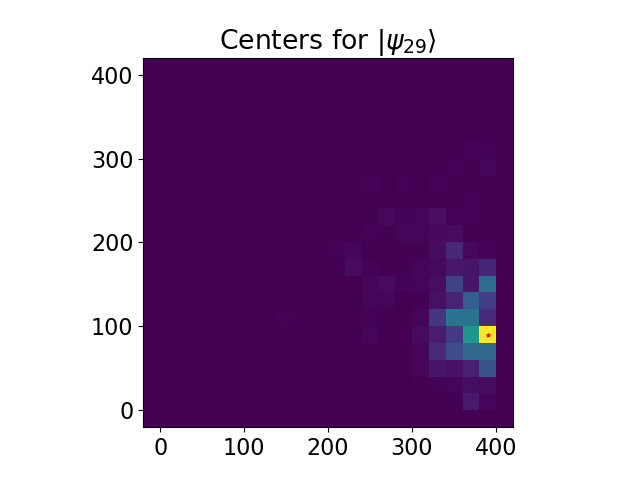

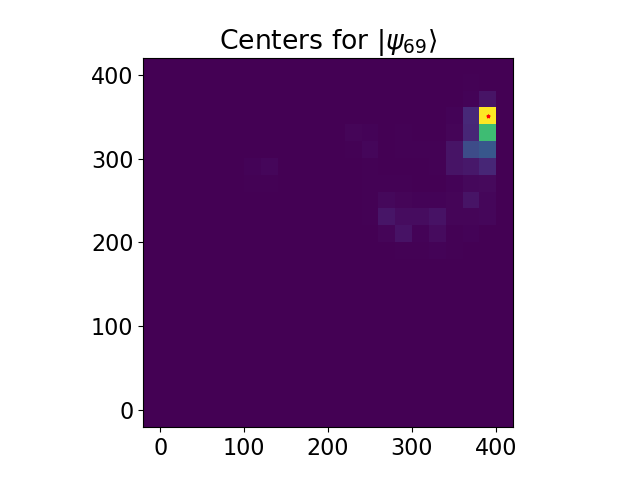

L =  {35, 28, 21, 103}
R =  {2, 3}
******* Left *******
35
28
21
103


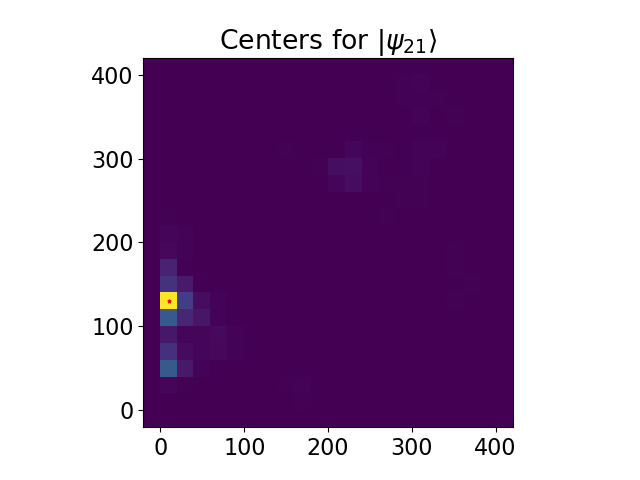

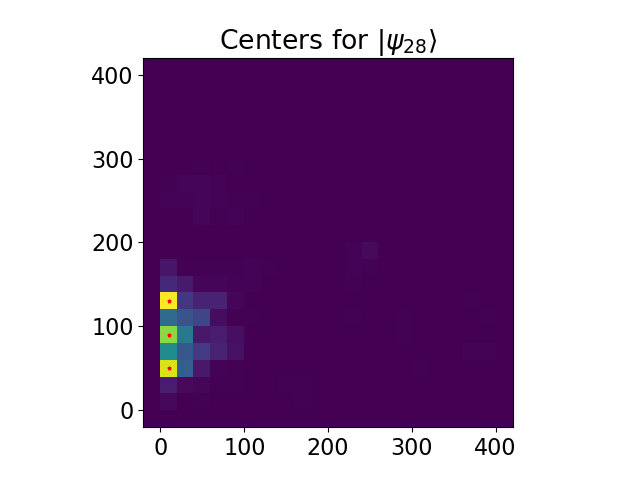

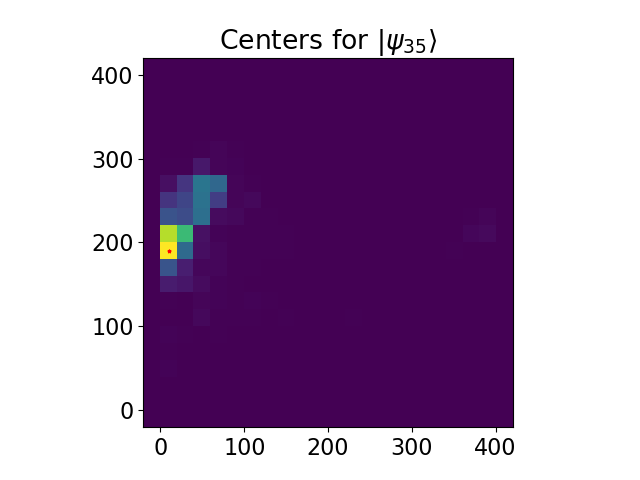

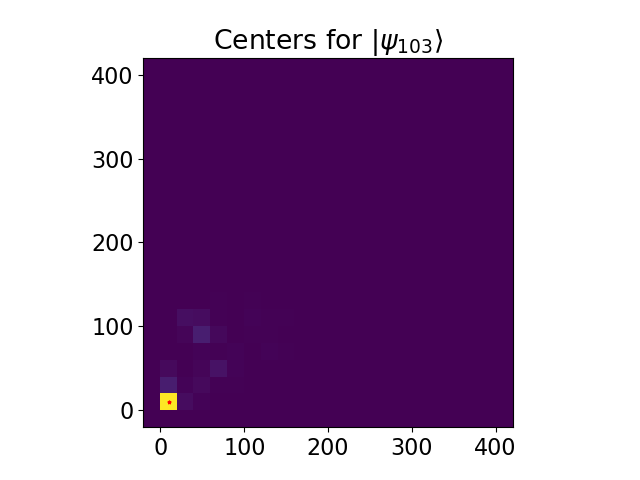

******* Right *******
2
3


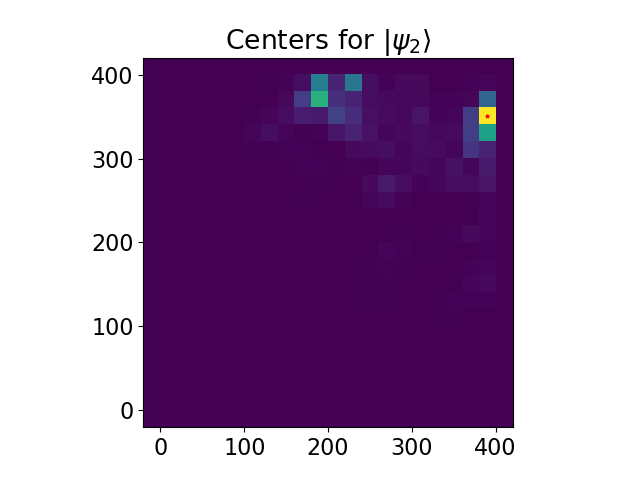

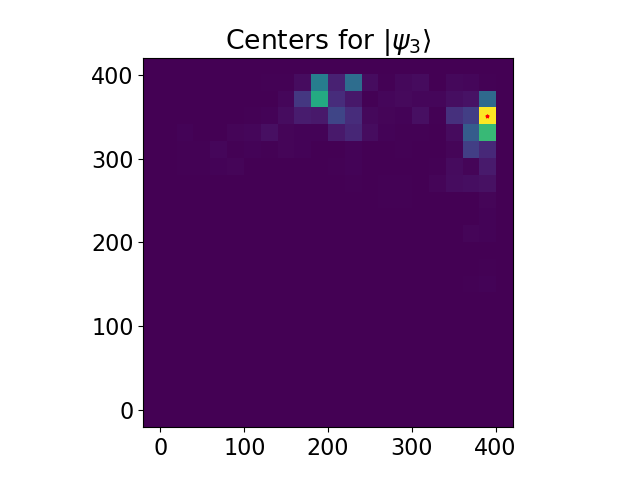

L =  {17, 10}
R =  {89, 1, 77, 55}
******* Left *******
17
10


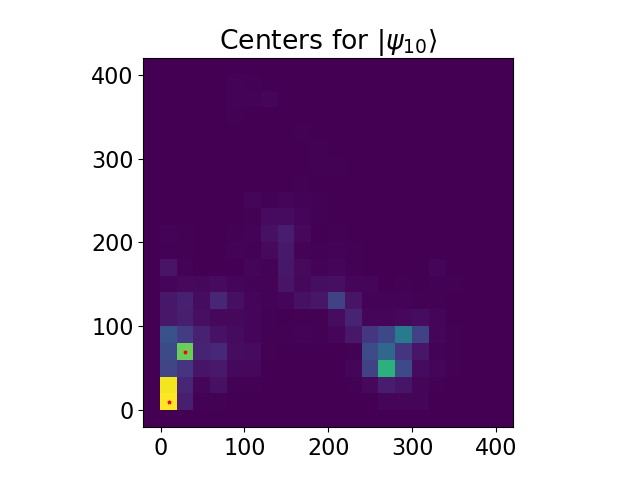

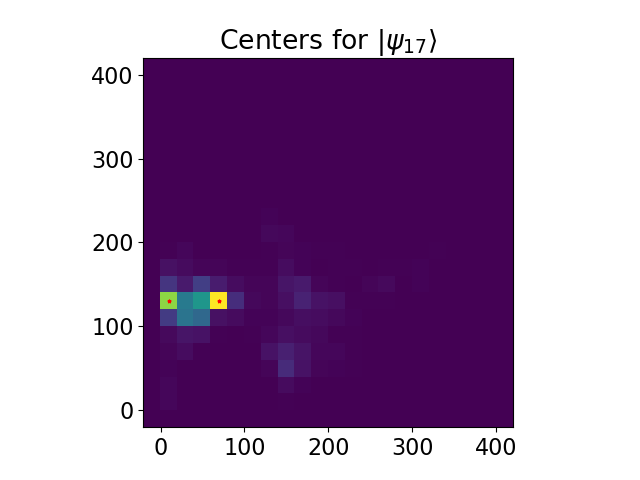

******* Right *******
89
1
77
55


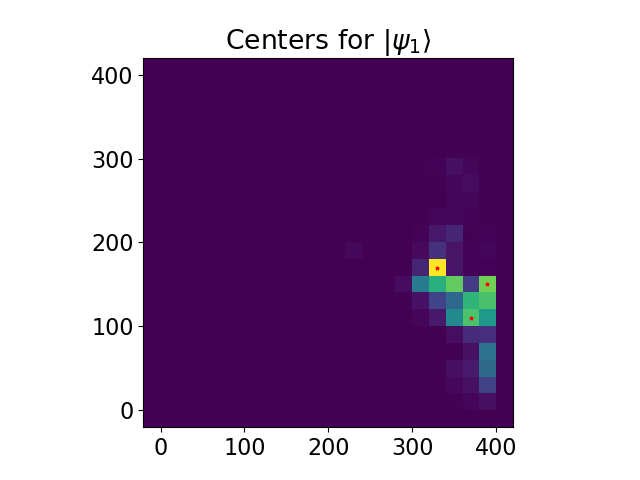

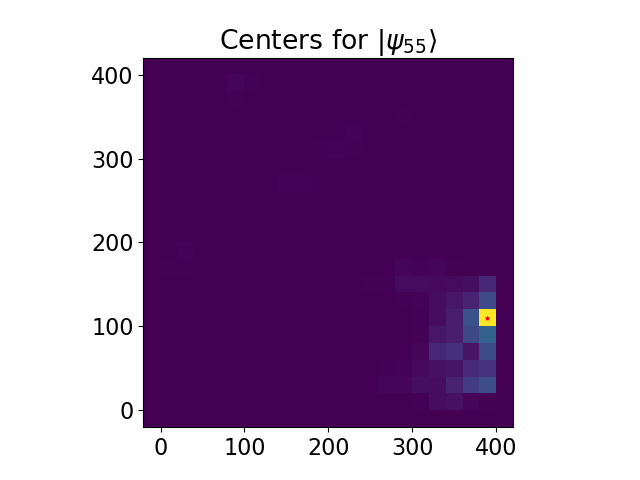

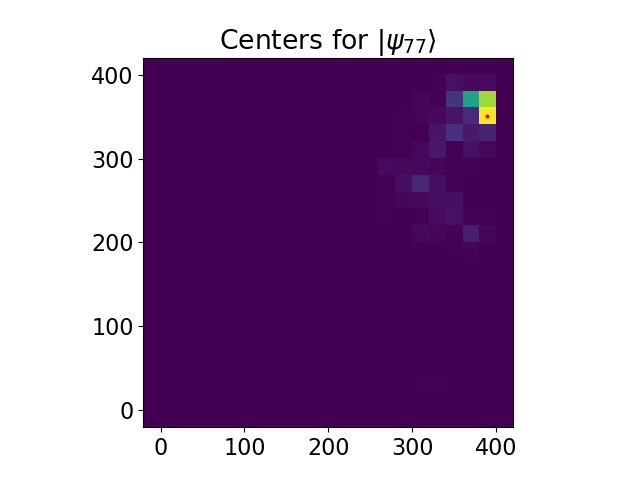

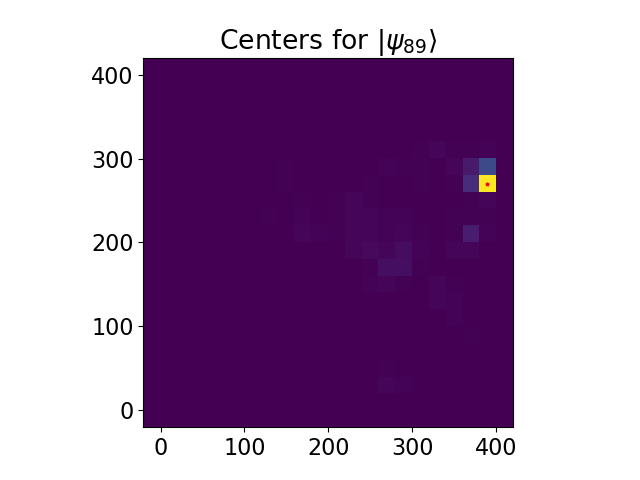

L =  {71, 72, 17, 19, 31}
R =  {107}
******* Left *******
71
!!! Generating new peaks !!!
[[  9.5581705  189.87344703]]
72
17
19
31


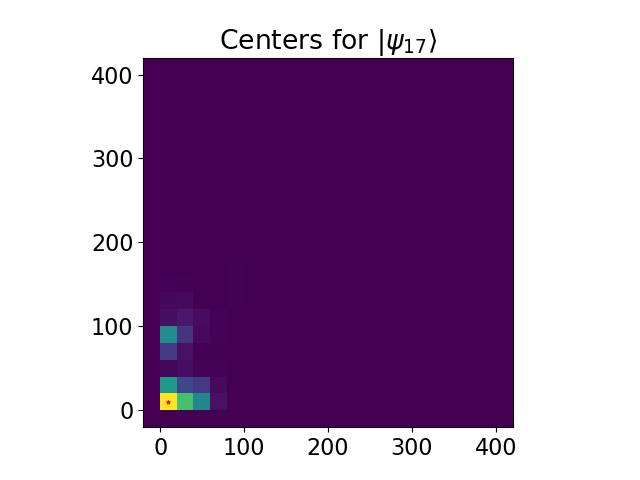

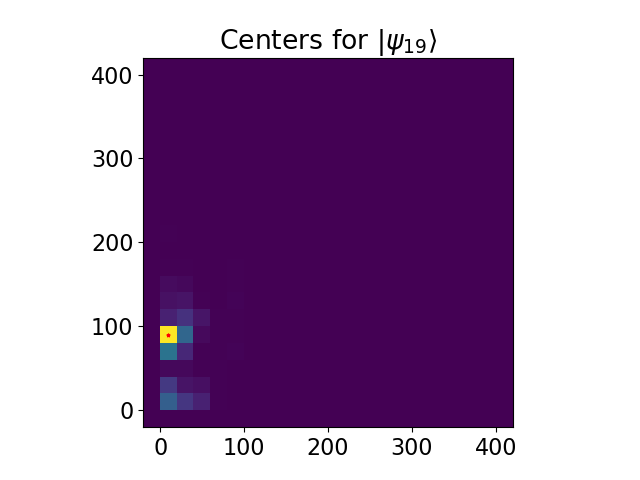

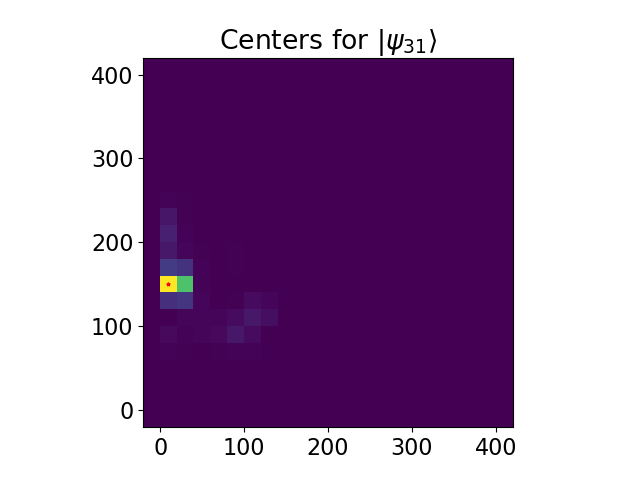

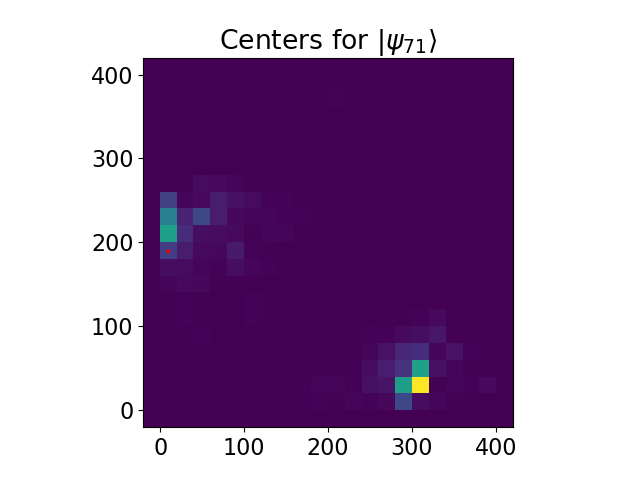

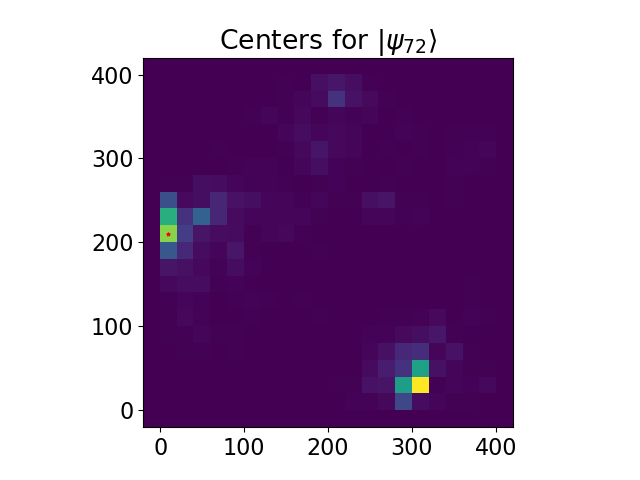

******* Right *******
107


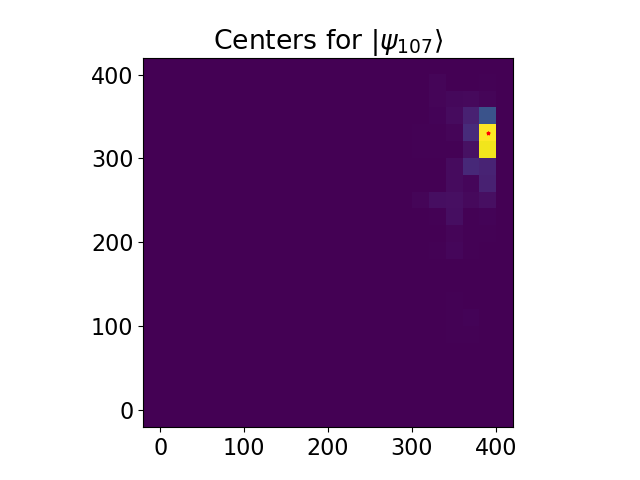

In [15]:
tolscal = 3.0
for s in bad_strucs:
    pos, M, energies, _, _, _, gamL, gamR = get_npy_data(s,datadir)
    ltol = np.mean(gamL) + tolscal*np.std(gamL)
    rtol = np.mean(gamR) + tolscal*np.std(gamR)
    L = set((gamL > ltol).nonzero()[0])
    print("L = ", L)
    R = set((gamR > rtol).nonzero()[0])
    print("R = ", R)
    print("******* Left *******")
    ccL, ee, ii = generate_site_list(pos,M,L,L,R,energies)
    # print(ccL.shape[0] == ee.shape[0])
    # print(ccL.shape[0] == ii.shape[0])
    for n in np.unique(ii):
        sites = ccL[ii==n,:]
        rho, xedges, yedges = gridifyMO(pos,M,n,20,True)
        fig, ax = plt.subplots()
        plot_loc_centers(rho, xedges, yedges, sites, colours='r', show=False, plt_objs=(fig,ax))
        ax.set_title('Centers for $|\psi_{%d}\\rangle$'%n)
        plt.show()
    
    print("******* Right *******")
    ccR, ee, ii = generate_site_list(pos,M,R,L,R,energies)
    # print(ccR.shape[0] == ee.shape[0])
    # print(ccR.shape[0] == ii.shape[0])
    for n in np.unique(ii):
        sites = ccR[ii==n,:]
        rho, xedges, yedges = gridifyMO(pos,M,n,20,True)
        fig, ax = plt.subplots()
        plot_loc_centers(rho, xedges, yedges, sites, colours='r', show=False, plt_objs=(fig,ax))
        ax.set_title('Centers for $|\psi_{%d}\\rangle$'%n)
        plt.show()
        